In [2]:
import d2l
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torch import nn

In [11]:
# load the pre-trained model resnet18
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = torch.nn.Linear(finetune_net.fc.in_features, 8)
torch.nn.init.xavier_uniform_(finetune_net.fc.weight);

In [12]:
# load the dataset 
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])
mydata = torchvision.datasets.ImageFolder('output_data_HSB/', transform=data_transforms)
num_train = int(len(mydata)*0.75)
train_data, test_data = torch.utils.data.random_split(mydata, [num_train, len(mydata)-num_train])

In [13]:
# train model
train_loss = []
train_accs = []
test_accs = []
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(finetune_net.parameters(),lr=1e-4,momentum=0.9)
num_epochs = 15
train_iter = DataLoader(train_data, 64, shuffle=True)
test_iter = DataLoader(test_data, 64)
for epoch in range(num_epochs):
    running_loss=0.00
    running_correct=0.0
    print("Epoch  {}/{}".format(epoch, num_epochs))
    
    for i,data in enumerate(train_iter,0):
        inputs,labels=data
        optimizer.zero_grad()
        outputs=finetune_net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _, pred = torch.max(outputs.data, 1)
        running_correct += torch.sum(pred == labels.data)
        
    l = running_loss / len(train_data)
    train_acc = running_correct / len(train_data)
    train_accs.append(train_acc)
    train_loss.append(l)

    with torch.no_grad():
        running_correct=0.00
        for i, data in enumerate(test_iter, 0):
            inputs, labels = data
            outputs = finetune_net(inputs)
            _, pred = torch.max(outputs.data, 1)
            running_correct += torch.sum(pred == labels.data)
        test_acc = running_correct / len(test_data)
        test_accs.append(test_acc)     
    print("Loss is :{:.4f}, Train Accuracy is:{:.4f}, Test Accuracy is:{:.4f}".format(l, train_acc, test_acc))

Epoch  0/15
Loss is :0.0267, Train Accuracy is:0.4310, Test Accuracy is:0.7374
Epoch  1/15
Loss is :0.0106, Train Accuracy is:0.8087, Test Accuracy is:0.8562
Epoch  2/15
Loss is :0.0070, Train Accuracy is:0.8798, Test Accuracy is:0.8945
Epoch  3/15
Loss is :0.0055, Train Accuracy is:0.9039, Test Accuracy is:0.9217
Epoch  4/15
Loss is :0.0047, Train Accuracy is:0.9163, Test Accuracy is:0.9241
Epoch  5/15
Loss is :0.0042, Train Accuracy is:0.9211, Test Accuracy is:0.9333
Epoch  6/15
Loss is :0.0038, Train Accuracy is:0.9308, Test Accuracy is:0.9357
Epoch  7/15
Loss is :0.0032, Train Accuracy is:0.9407, Test Accuracy is:0.9386
Epoch  8/15
Loss is :0.0033, Train Accuracy is:0.9351, Test Accuracy is:0.9420
Epoch  9/15
Loss is :0.0031, Train Accuracy is:0.9405, Test Accuracy is:0.9438
Epoch  10/15
Loss is :0.0027, Train Accuracy is:0.9492, Test Accuracy is:0.9455
Epoch  11/15
Loss is :0.0026, Train Accuracy is:0.9515, Test Accuracy is:0.9513
Epoch  12/15
Loss is :0.0026, Train Accuracy is:0.

In [14]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

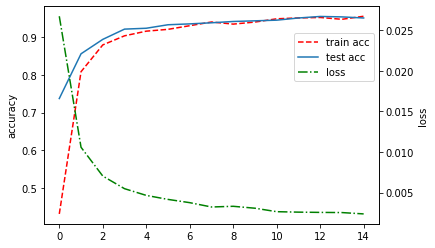

In [15]:
# plot the graph
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
x = range(num_epochs)
ax1.plot(x, train_accs, 'r--', label='train acc')
ax1.plot(x, test_accs, label='test acc')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax2.plot(x, train_loss, 'g-.', label='loss')
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9), bbox_transform=ax1.transAxes)

In [16]:
# tensor data to image
def tensor2im(input_image, imtype=np.uint8):
    
    mean = [0.485,0.456,0.406] #mean parameter in dataLoader
    std = [0.229,0.224,0.225]  #std parameter in dataLoader
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor): #if input image format is torch.Tensor，
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255 #[0,1]convert to [0,255]
        image_numpy = np.transpose(image_numpy, (1, 2, 0))  # convert(channels, height, width)to(height, width, channels)
    else:  # if numpy,do thing 
        image_numpy = input_image
    return image_numpy.astype(imtype)

# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

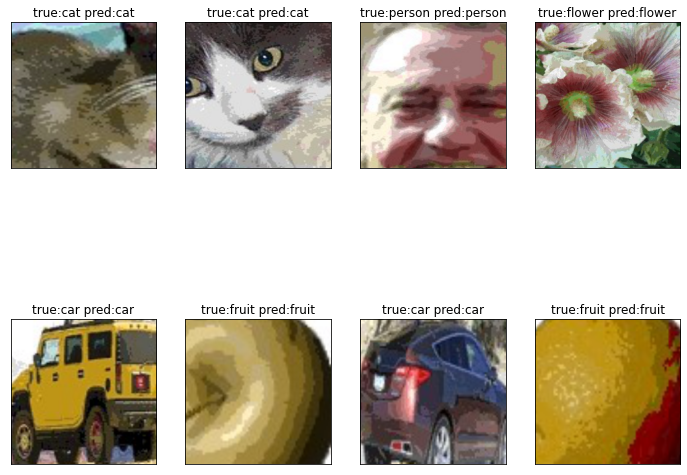

In [17]:
# predictive results 
classes = [i.split('_')[0] for i in mydata.classes]
with torch.no_grad():
    inputs, labels = iter(test_iter).next()
    outputs = finetune_net(inputs[:8])
    _, pred = torch.max(outputs.data, 1)
    plt.figure(figsize=(12,10))
    num = 0
    while num < 8:
        plt.subplot(2, 4, num+1)
        img = tensor2im(inputs[num])
        disp_image(np.array(img))
        plt.title(f"true:{classes[labels[num]]} pred:{classes[pred[num]]}")
        num += 1

In [88]:
# save the training model
torch.save(finetune_net, 'model.pt')